# Supervised Learning: More Classification

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
print(sys.executable)
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/bin/python3.11


## Learning Goals
- Practice implementing classifier algorithms
- Compare different SVM models and kernels
- Understand when to use LinearSVC vs. different kernel functions
- Interpret confusion matrices, precision, and recall in real-world contexts

----

### Review of the Confusion Matrix
After training a model, one of the most common evaluation tools we use is a **confusion matrix**. It shows how many predictions your model got right and wrong — broken down by class.
<p align="left">
    <img src = "https://www.blog.trainindata.com/wp-content/uploads/2024/09/confusion-matrix-1.png" width = "400">
</p>

From these values, we can calculate:
- **Accuracy** = (TP + TN) / Total → How many predictions were correct overall.
- **Precision** = TP / (TP + FP) → Of all the points the model said were positive, how many really were?
- **Recall** = TP / (TP + FN) → Of all the true positives, how many did the model actually find?

For example, if you wanted to evalute the performance of a flower classifier:
- **True Positive (TP):** correctly identified a <span style="color: red">red</span> flower as <span style="color: red">red</span>
- **False Positive (FP):** mislabeled a <span style="color: yellow">yellow</span> flower as <span style="color: red">red</span> → a false alarm
- **False Negative (FN):** missed a <span style="color: red">red</span> flower and called it <span style="color: yellow">yellow</span> → a missed detection
- **True Negative (TN):** correctly labeled a <span style="color: yellow">yellow</span> flower as <span style="color: yellow">yellow</span>

By reading the confusion matrix, you can tell *what kinds of mistakes* your model is making — not just how many.

----

## Problem 1: Building a Basic LinearSVC Classifier

Imagine you're a **data scientist at a hospital** trying to predict whether a patient has a certain medical condition based on two measurements:
- **Blood Pressure** (systolic)
- **Cholesterol Level**

You've collected data from 200 patients, and fortunately, the two groups seem to be roughly separable by a straight line. This makes **LinearSVC** a great choice — it's fast and works well when data is linearly separable.

### Dataset: Medical Screening Data
Let's generate a synthetic dataset that mimics this scenario.

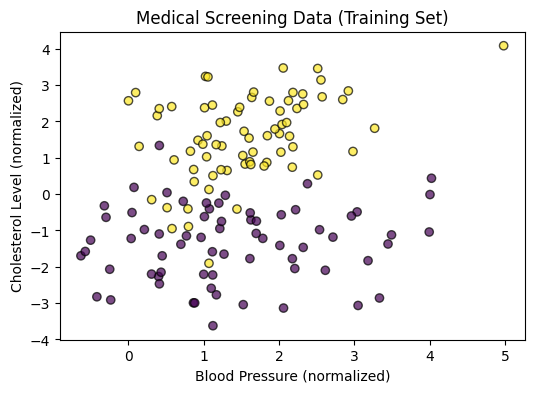

Training samples: 140
Testing samples: 60
Class distribution: [68 72]


In [24]:
# Generate a linearly separable dataset for medical screening
from sklearn.datasets import make_classification

X1, y1 = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    flip_y=0.05,  # 5% label noise to make it realistic
    class_sep=1.5,
    random_state=42
)

# Split into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

# Visualize the dataset
plt.figure(figsize=(6,4))
plt.scatter(X1_train[:,0], X1_train[:,1], c=y1_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('Medical Screening Data (Training Set)')
plt.xlabel('Blood Pressure (normalized)')
plt.ylabel('Cholesterol Level (normalized)')
plt.show()

print(f"Training samples: {len(X1_train)}")
print(f"Testing samples: {len(X1_test)}")
print(f"Class distribution: {np.bincount(y1_train)}")

### Q: Build and Evaluate a LinearSVC Model

Your task is to:
1. **Create** a `LinearSVC` model
2. **Train** it on the training data
3. **Make predictions** on the test set
4. **Evaluate** the results using a confusion matrix and classification report

Follow the skeleton code below to complete each step.

In [25]:
# Step 1: Create a LinearSVC model
# YOUR CODE HERE
model = LinearSVC()

# Step 2: Train the model on the training data
# YOUR CODE HERE
model.fit(X1_train, y1_train)

# Step 3: Make predictions on the test set
# YOUR CODE HERE
y1_pred = model.predict(X1_test)

# Step 4: Evaluate the model
# Confusion Matrix
# YOUR CODE HERE
print('Confusion Matrix:\n', confusion_matrix(y1_test,y1_pred))

# Classification Report
# YOUR CODE HERE
print('\nClassification Report:\n', classification_report(y1_test,y1_pred))

Confusion Matrix:
 [[28  1]
 [ 4 27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
           1       0.96      0.87      0.92        31

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



### Q: Interpret Your Results

Looking at the confusion matrix and classification report, answer the following:

1. **Why did we choose LinearSVC for this problem?** (Hint: Look at the scatter plot of the data)
2. **What is the model's precision and recall?** Which one is higher?
3. **In a medical context**, would you prefer higher precision or higher recall? Why?
4. **Looking at the confusion matrix**: Did the model make more False Positives or False Negatives? What does this mean for patients?

### A:
1. If we have some horizontal line, we should be able to classify the data.
2. The model's precision is 28/32 and the recall is 28/29. The recall is higher.
3. We prefer higher recall because getting a false negative is a lot worse than getting a false positive.
4. There were more false negatives which meant that the patients were not told that they had the condition which could lead to failure to recieve the necessary treatment -- potentially deadly.

### Visualize the Decision Boundary

Let's see how the LinearSVC model separates the two classes with a straight line.

<Figure size 800x500 with 0 Axes>

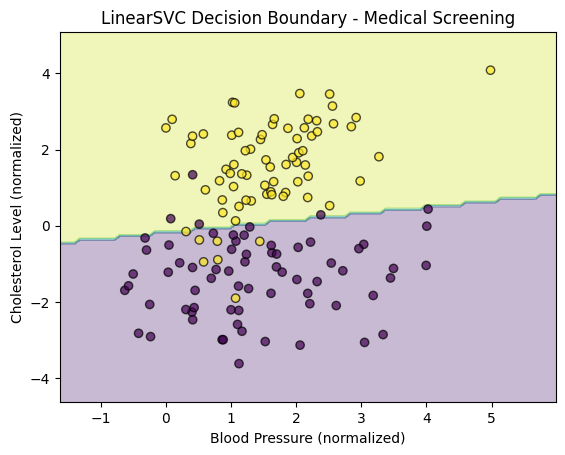

In [26]:
# Visualize the decision boundary
# Uncomment this code after training your model

plt.figure(figsize=(8,5))
DecisionBoundaryDisplay.from_estimator(
     model, X1_train, response_method='predict', 
     cmap='viridis', alpha=0.3
 )
plt.scatter(X1_train[:,0], X1_train[:,1], c=y1_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('LinearSVC Decision Boundary - Medical Screening')
plt.xlabel('Blood Pressure (normalized)')
plt.ylabel('Cholesterol Level (normalized)')
plt.show()

## Comparing Kernels 🍿
Imagine you’re a **botanist trying to classify flowers** growing in a garden. You measure two features for each flower:
- **Petal Width** (x-axis)
- **Petal Length** (y-axis)

Some flowers grow in **two curved patches** on opposite corners of the garden — a bit like crescent moons. We’ll try to teach a computer to separate them using different SVM kernels.

### What is a Kernel?
A kernel function helps an SVM draw boundaries between classes. The cool part is that kernels can transform data into higher-dimensional spaces — so curved data can become separable!

| Kernel | Shape of Boundary | When Useful |
|--|--|--|
| Linear | Straight line | Data looks mostly separable by a flat edge |
| Polynomial | Curved and flexible | Data has smooth bends (like petals curving outward) |
| RBF | Highly flexible | Data has tight circles or complex spirals |

Let’s generate a dataset that mimics our garden: two types of flowers arranged in a curved pattern.

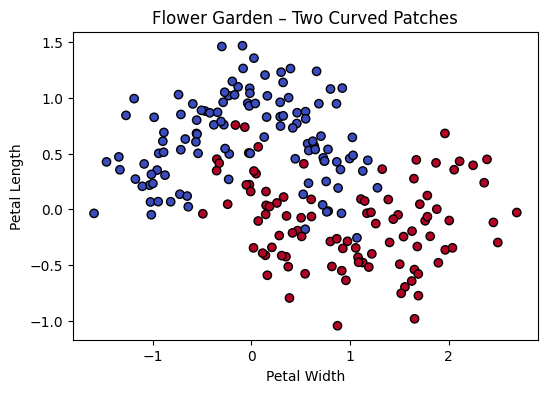

In [27]:
# Generate non-linear dataset representing our 'flower garden' pattern
X2, y2 = make_moons(n_samples=300, noise=0.25, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

plt.figure(figsize=(6,4))
plt.scatter(X2_train[:,0], X2_train[:,1], c=y2_train, cmap='coolwarm', edgecolor='k')
plt.title('Flower Garden – Two Curved Patches')
plt.xlabel('Petal Width')
plt.ylabel('Petal Length')
plt.show()

### Q: Train a `LinearSVC` model and discuss the following:
- What kind of line do you expect it to draw?
- Would it work well to split the two curved flower patches?

In [29]:
# YOUR CODE HERE
linear_moons = LinearSVC()
linear_moons.fit(X2_train, y2_train)
y2_pred_linear = linear_moons.predict(X2_test)

print('Confusion Matrix (LinearSVC):\n', confusion_matrix(y2_test, y2_pred_linear))
print('\nClassification Report (LinearSVC):\n', classification_report(y2_test, y2_pred_linear))

Confusion Matrix (LinearSVC):
 [[33  5]
 [ 5 47]]

Classification Report (LinearSVC):
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        38
           1       0.90      0.90      0.90        52

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



### Q: Train an SVM with a linear kernel 
Note: You should use `SVC(kernel='linear')`.
- How does this compare to your `LinearSVC`?
- What happens if the data has just a little bit of curve?

In [31]:
# YOUR CODE HERE
svc_lin = SVC(kernel='linear')
svc_lin.fit(X2_train, y2_train)
y2_pred_lin = svc_lin.predict(X2_test)

print('Confusion Matrix (SVC Linear):\n', confusion_matrix(y2_test, y2_pred_lin))
print('\nClassification Report (SVC Linear):\n', classification_report(y2_test, y2_pred_lin))

Confusion Matrix (SVC Linear):
 [[32  6]
 [ 4 48]]

Classification Report (SVC Linear):
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        38
           1       0.89      0.92      0.91        52

    accuracy                           0.89        90
   macro avg       0.89      0.88      0.89        90
weighted avg       0.89      0.89      0.89        90



### A: 

1. I think they perform the same way. The LinearSVC is a little faster.
2. If the data has a little bit of a curve, you should probably use SVC(kernel='rbf') because otherwise the model will struggle to find a good linear boundary.

Next, let’s use the **RBF (Radial Basis Function)** kernel. 

This kernel can handle **curved or circular data**, which makes it great for flower patches that grow in arcs.

### Q: Train an SVM with an RBF kernel
Note: You should use `SVC(kernel='rbf')`

How do you expect this model to perform compared to the linear ones?

In [33]:
# YOUR CODE HERE
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X2_train, y2_train)
y2_pred_rbf = svc_rbf.predict(X2_test)

print('Confusion Matrix (SVC RBF):\n', confusion_matrix(y2_test, y2_pred_rbf))
print('\nClassification Report (SVC RBF):\n', classification_report(y2_test, y2_pred_rbf))

Confusion Matrix (SVC RBF):
 [[33  5]
 [ 4 48]]

Classification Report (SVC RBF):
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        38
           1       0.91      0.92      0.91        52

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90



### A: 
It's expected to perform better than linear kernels on mroe complex data. It can handle more curved boundaries.

Finally, let’s test a **polynomial kernel** with degree 3. This kernel can learn gentle curves — imagine fitting a flexible ribbon around the garden to separate flower types. 

### Q: Train an SVM with a polynominal, degree=3 kernel
Note: You should use `SVC(kernel='poly', degree=3)`

Does it perform closer to RBF or linear?

In [34]:
# YOUR CODE HERE
svc_poly = SVC(kernel='poly', degree=3)
svc_poly.fit(X2_train, y2_train)
y2_pred_poly = svc_poly.predict(X2_test)

print('Confusion Matrix (SVC Polynomial):\n', confusion_matrix(y2_test, y2_pred_poly))
print('\nClassification Report (SVC Polynomial):\n', classification_report(y2_test, y2_pred_poly))

Confusion Matrix (SVC Polynomial):
 [[33  5]
 [ 5 47]]

Classification Report (SVC Polynomial):
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        38
           1       0.90      0.90      0.90        52

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



### A: 
I think it will perform closer to the RBF kernel because it's non linear and can make a more curved boundary.

----

## Visualizing All Four Kernels
Let’s see how each kernel draws its decision boundary. Think of these as invisible fences separating the two flower species.

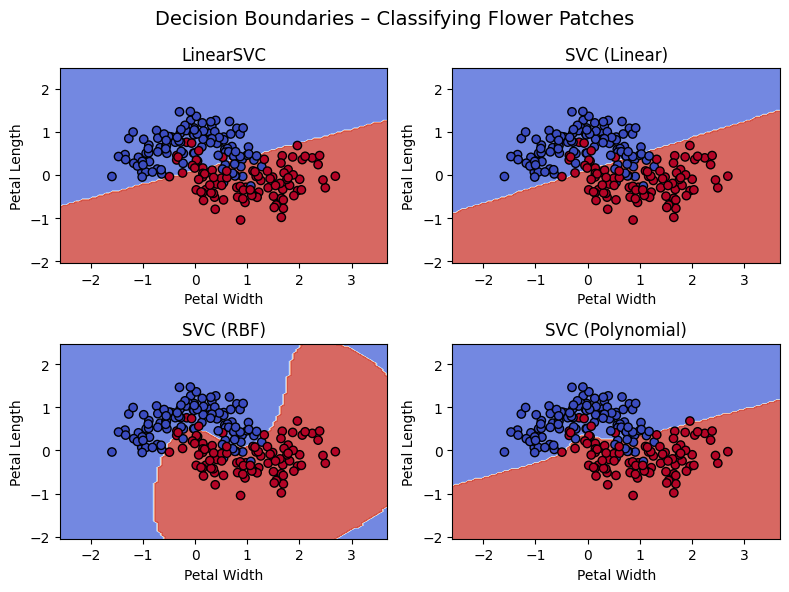

In [35]:
models = {
  'LinearSVC': linear_moons,
  'SVC (Linear)': svc_lin,
  'SVC (RBF)': svc_rbf,
  'SVC (Polynomial)': svc_poly
}

fig, axes = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
plt.suptitle('Decision Boundaries – Classifying Flower Patches', fontsize=14)
axes = axes.ravel()

for ax, (name, mdl) in zip(axes, models.items()):
  DecisionBoundaryDisplay.from_estimator(
    mdl, X2_train, response_method='predict', cmap='coolwarm', alpha=0.8, ax=ax
  )
  ax.scatter(X2_train[:,0], X2_train[:,1], c=y2_train, cmap='coolwarm', edgecolor='k')
  ax.set_title(name)
  ax.set_xlabel('Petal Width'); ax.set_ylabel('Petal Length')

plt.show()

## Reflection Questions
1. Which kernel handled the curved pattern best? How can you tell from the plot?
2. If your garden had more irregular patterns, which kernel would you experiment with next?
3. Did the models with more complex kernels always perform better? Why or why not?

### A:
1. The RBF kernel handled the curved pattern the best. The data points don't have a nice linear boundary and the RBF kernel outlines the best.
2. I would experiment with the RBF kernel because it can handle more irregular patterns that don't necessarily have a clear cut linear boundary.
3. No, because the more complex models will probably take outliers into account even if they don't follow the general patter. This may lead overfitting. Also, the model may take longer then more simple ones.